<div style="display: flex; align-items: center; gap: 30px; padding-bottom: 10px;">
    <img src="./fig/logo/logo_fwc.png" alt="Logo" style="width: 150px">
    <div>
        <h1 style="margin: 0; font-size: 2.0em;">TFM - Inteligencia Artificial para la Observación de la Tierra: Comparación de modelos para la Monitorización de la vegetación</h1>
        <h1></h1>
        <h2 style="margin: 5px 0 0 0; color: #555; font-size: 1.5em;">Adolfo Molada Tebar</h2>
    </div>
</div>

---
## RANDOM FOREST - Feature Importance

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import display_functions
import helper_functions
import model_functions

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### Preparar el entorno de trabajo

In [3]:
current_dir = os.getcwd()

project_dir = os.path.join(current_dir, "fwc")
project_data = os.path.join(project_dir, "data")

project_data_training = os.path.join(project_data, "training")
project_models = os.path.join(project_dir,"models")

### Cargar los datos

In [4]:
feather_file_path = os.path.join(project_data_training, "data.feather")
data = helper_functions.load_feather_as_df(feather_file_path)

In [5]:
data.describe()

,sample_id,label,R,G,B,H,S,V,L,a,...,vari,gli,cive,rgbvi,ngrdi,tgi,L_perc,gr,gb,rb
count,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,...,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000
mean,15466.359788,0.433862,0.328589,0.349635,0.318131,0.354350,0.157438,0.357195,36.823065,-3.634057,...,0.098274,0.038967,18.770834,0.081939,0.043530,2.626863,0.342886,1.098454,1.086219,1.007287
std,7144.236501,0.608058,0.139269,0.127110,0.099329,0.159418,0.081765,0.130633,13.412162,2.665701,...,0.137972,0.025428,0.013241,0.052172,0.054708,2.116683,0.126894,0.132174,0.115080,0.191885
min,1.000000,0.000000,0.047059,0.086275,0.101961,0.061111,0.016129,0.101961,7.438742,-14.478152,...,-0.153846,-0.053763,18.717208,-0.102035,-0.098182,-2.450980,0.087484,0.821191,0.782604,0.437497
25%,6746.500000,0.000000,0.223529,0.258824,0.250980,0.212121,0.100893,0.260784,27.078731,-5.235742,...,0.021016,0.024955,18.763414,0.052272,0.011494,1.392157,0.250305,1.023251,1.012119,0.880594
50%,17646.000000,0.000000,0.309804,0.341176,0.317647,0.370370,0.137615,0.341176,35.882136,-3.757126,...,0.081967,0.038835,18.771643,0.080373,0.042105,2.333333,0.330585,1.087909,1.077919,0.977270
75%,17798.500000,1.000000,0.401961,0.419608,0.376471,0.484848,0.202290,0.423529,44.579033,-2.167105,...,0.155050,0.052012,18.778433,0.110365,0.073529,3.588235,0.413051,1.158725,1.141356,1.090591
max,29255.000000,2.000000,0.792157,0.835294,0.764706,0.888889,0.562500,0.835294,83.894231,6.945201,...,1.363605,0.152000,18.812741,0.358478,0.358489,11.352941,0.819611,2.117615,1.607835,1.737494


In [6]:
data.sample(5)

,sample_id,label,R,G,B,H,S,V,L,a,...,vari,gli,cive,rgbvi,ngrdi,tgi,L_perc,gr,gb,rb
350,171,1,0.254902,0.258824,0.207843,0.179487,0.196970,0.258824,27.510715,-3.107978,...,0.012820,0.056000,18.769525,0.116779,0.007634,3.196078,0.254309,1.015381,1.245277,1.226409
407,27481,0,0.321569,0.321569,0.200000,0.166667,0.378049,0.321569,34.123276,-5.526127,...,0.000000,0.104377,18.745020,0.233081,0.000000,7.294118,0.312791,0.999997,1.607835,1.607835
245,17836,1,0.337255,0.345098,0.325490,0.233333,0.056818,0.345098,37.082292,-1.851831,...,0.021978,0.020290,18.781169,0.040720,0.011494,1.450980,0.342015,1.023253,1.060238,1.036141
133,6648,1,0.423529,0.443137,0.388235,0.226190,0.123894,0.443137,46.842055,-4.685223,...,0.040984,0.043880,18.763863,0.088530,0.022624,3.980392,0.435005,1.046294,1.141411,1.090906
118,17541,0,0.121569,0.156863,0.168627,0.541667,0.279070,0.168627,15.399072,-3.066790,...,0.321426,0.038961,18.778318,0.091031,0.126760,0.529412,0.150209,1.290312,0.930227,0.720926


### Datos

In [7]:
X = data.iloc[:, 2:] # variables / features
y = data.iloc[:, 1]  # etiquetas

print(X.shape)
print(y.shape)

(567, 26)
(567,)


## Análisis importancia de las variables empleadas en el modelo

En Random Forest, el análisis de importancia se basa en la reducción de impureza (_Mean Decrease in Impurity_, MDI). Se calcula durante el entrenamiento del bosque sumando la reducción del índice Gini (o Entropía) que cada variable genera en todos los nodos de todos los árboles.

En los modelos Random Forest, la relevancia de una variable se evalúa a partir de su contribución a la reducción de la impureza de los nodos en los árboles que componen el bosque. Esta medida se conoce como _Mean Decrease in Impurity (MDI)_ y constituye el criterio utilizado por defecto en la implementación de _RandomForestClassifier_ de _scikit-learn_.

A diferencia de los métodos de _boosting_, en Random Forest los árboles se construyen de manera independiente, empleando subconjuntos aleatorios de muestras y variables, lo que permite estimar la importancia de cada variable a partir de su efecto medio en la estructura del bosque.

### Load Random forest best model

In [8]:
rf_best_model_path = os.path.join(project_models, "rf_best_model.pkl")
rf_best_model = model_functions.load_model(rf_best_model_path)

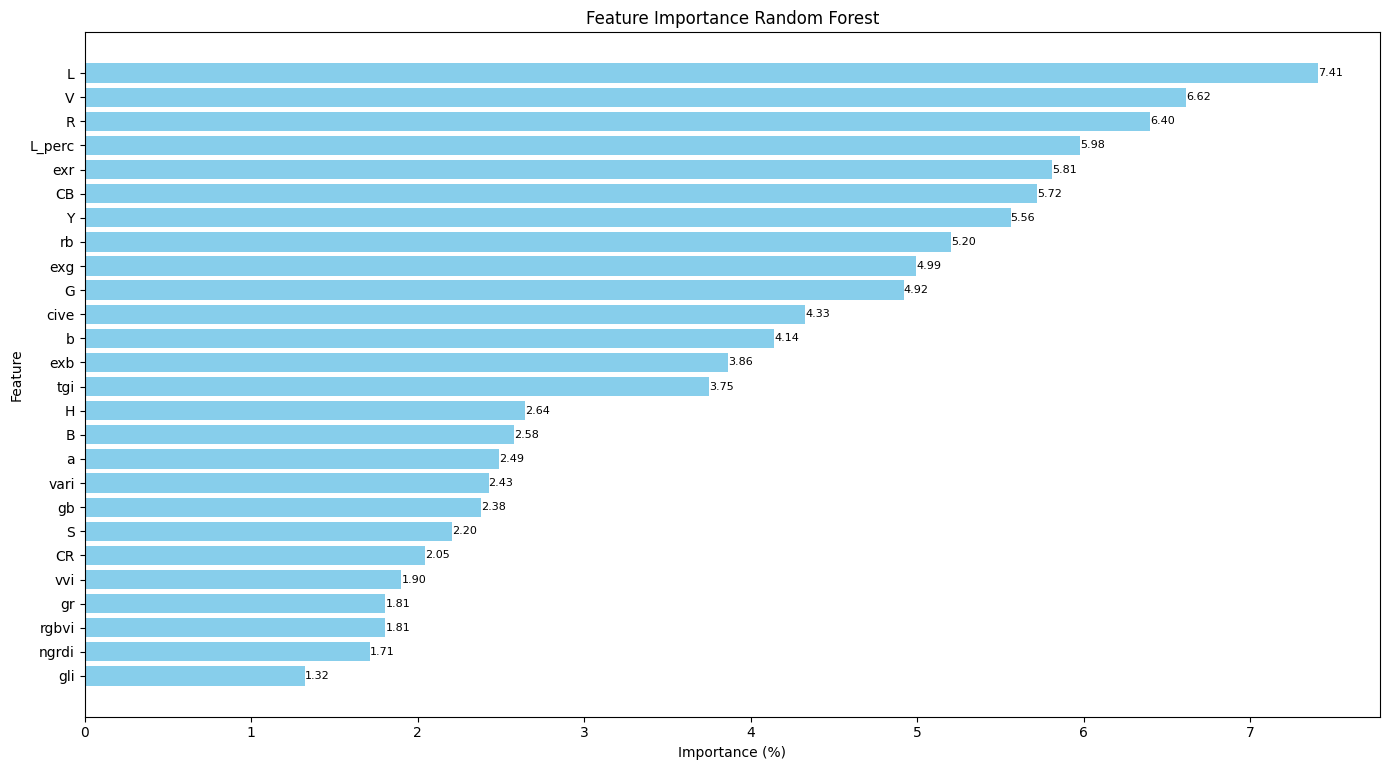

In [9]:
feature_names = X.columns
model_name = "Random Forest"

df_importances = model_functions.compute_feature_importance(rf_best_model, feature_names, model_name)

In [10]:
df_importances

,feature,importance,importance_pct
6,L,0.074075,7.407514
5,V,0.066155,6.615515
0,R,0.063994,6.399419
22,L_perc,0.059763,5.976287
13,exr,0.058111,5.811093
10,CB,0.057164,5.716391
9,Y,0.055599,5.559910
25,rb,0.052020,5.201994
12,exg,0.049916,4.991602
1,G,0.049178,4.917828


In [11]:
# Calcular la importancia acumulada
df_importances["cum_importance"] = df_importances["importance"].cumsum()

# Seleccionar las variables necesarias para cubrir al menos el 90%
selected_features = df_importances[df_importances["cum_importance"] <= 0.90]["feature"].tolist()

# Incluir la primera variable que supera el 90% si no se ha incluido
if df_importances["cum_importance"].iloc[len(selected_features)] < 1.0:
    selected_features.append(df_importances["feature"].iloc[len(selected_features)])

# Calcular la importancia acumulada explicada por las variables seleccionadas
cum_explained = df_importances[df_importances["feature"].isin(selected_features)]["importance"].sum()

print("Variables seleccionadas:", selected_features)
print(f"Importancia acumulada explicada: {cum_explained*100:.2f}%")

Variables seleccionadas: ['L', 'V', 'R', 'L_perc', 'exr', 'CB', 'Y', 'rb', 'exg', 'G', 'cive', 'b', 'exb', 'tgi', 'H', 'B', 'a', 'vari', 'gb', 'S', 'CR']
Importancia acumulada explicada: 91.45%


#### Interpretación



In [12]:
total_variable_names = data.columns

dropped_features = [name for name in list(set(total_variable_names) ^ set(selected_features)) if name not in ["sample_id","label"]]  # ^ es XOR: elementos en uno u otro, pero no en ambos
print("Variables eliminadas: ", dropped_features)  # aparece "sample_id" y "label", que no hay que considerarlas

Variables eliminadas:  ['rgbvi', 'gr', 'gli', 'vvi', 'ngrdi']


In [13]:
df_selected = data.drop(columns=dropped_features)

In [14]:
df_selected

,sample_id,label,R,G,B,H,S,V,L,a,...,CR,exg,exr,exb,vari,cive,tgi,L_perc,gb,rb
0,17679,0,0.101961,0.160784,0.160784,0.500000,0.365854,0.160784,15.305140,-6.286540,...,121.411765,0.058824,-0.018039,0.058824,0.576917,18.763471,2.058824,0.148278,0.999994,0.634142
1,6623,0,0.407843,0.423529,0.403922,0.300000,0.046296,0.423529,45.147446,-2.567310,...,126.600275,0.035294,0.147451,-0.023529,0.036697,18.778886,1.725490,0.418779,1.048541,1.009706
2,197,1,0.380392,0.396078,0.372549,0.277778,0.059406,0.396078,42.269328,-2.801567,...,126.671702,0.039216,0.136471,-0.031373,0.038835,18.776965,1.960784,0.391045,1.063155,1.021050
3,17600,0,0.419608,0.474510,0.450980,0.428571,0.115702,0.474510,49.542282,-6.465057,...,122.279545,0.078431,0.112941,0.007843,0.123894,18.760847,3.333333,0.461139,1.052172,0.930433
4,17556,0,0.054902,0.113725,0.125490,0.527778,0.562500,0.125490,9.611652,-5.361800,...,121.197482,0.047059,-0.036863,0.082353,1.363605,18.767294,1.352941,0.102069,0.906243,0.437497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,17867,1,0.501961,0.529412,0.482353,0.263889,0.088889,0.529412,55.428130,-4.936658,...,125.782620,0.074510,0.173333,-0.066667,0.050000,18.764718,3.784314,0.520178,1.097559,1.040648
563,28753,0,0.282353,0.294118,0.301961,0.566667,0.064935,0.301961,31.682841,-0.769526,...,126.539498,0.003922,0.101176,0.027451,0.042857,18.789243,-0.058824,0.292183,0.974023,0.935062
564,17763,1,0.372549,0.411765,0.360784,0.294872,0.123810,0.411765,43.224699,-6.538756,...,124.536400,0.090196,0.109804,-0.062745,0.092592,18.756255,4.431373,0.399747,1.141301,1.032606
565,17790,0,0.341176,0.380392,0.360784,0.416667,0.103093,0.380392,40.160845,-4.961697,...,123.964980,0.058824,0.097255,0.000000,0.108695,18.767863,2.549020,0.370639,1.054345,0.945650


In [15]:
df_selected.describe()

,sample_id,label,R,G,B,H,S,V,L,a,...,CR,exg,exr,exb,vari,cive,tgi,L_perc,gb,rb
count,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,...,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000
mean,15466.359788,0.433862,0.328589,0.349635,0.318131,0.354350,0.157438,0.357195,36.823065,-3.634057,...,126.216611,0.052550,0.110389,-0.041961,0.098274,18.770834,2.626863,0.342886,1.086219,1.007287
std,7144.236501,0.608058,0.139269,0.127110,0.099329,0.159418,0.081765,0.130633,13.412162,2.665701,...,3.845523,0.035777,0.075339,0.102659,0.137972,0.013241,2.116683,0.126894,0.115080,0.191885
min,1.000000,0.000000,0.047059,0.086275,0.101961,0.061111,0.016129,0.101961,7.438742,-14.478152,...,117.498298,-0.043137,-0.047843,-0.423529,-0.153846,18.717208,-2.450980,0.087484,0.782604,0.437497
25%,6746.500000,0.000000,0.223529,0.258824,0.250980,0.212121,0.100893,0.260784,27.078731,-5.235742,...,123.729396,0.031373,0.058039,-0.082353,0.021016,18.763414,1.392157,0.250305,1.012119,0.880594
50%,17646.000000,0.000000,0.309804,0.341176,0.317647,0.370370,0.137615,0.341176,35.882136,-3.757126,...,125.793271,0.047059,0.093333,-0.019608,0.081967,18.771643,2.333333,0.330585,1.077919,0.977270
75%,17798.500000,1.000000,0.401961,0.419608,0.376471,0.484848,0.202290,0.423529,44.579033,-2.167105,...,127.682337,0.074510,0.147451,0.031373,0.155050,18.778433,3.588235,0.413051,1.141356,1.090591
max,29255.000000,2.000000,0.792157,0.835294,0.764706,0.888889,0.562500,0.835294,83.894231,6.945201,...,143.155137,0.188235,0.365490,0.117647,1.363605,18.812741,11.352941,0.819611,1.607835,1.737494


## Entrenamiento con las variables seleccionadas

### Evaluación del modelo con los atributos seleccionados

In [16]:
X = df_selected.iloc[:, 2:] # variables / features
y = data.iloc[:, 1]  # etiquetas

print(X.shape)
print(y.shape)

(567, 21)
(567,)


### Hold-out externo

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
print(X_train.shape)
print(X_test.shape)

(453, 21)
(114, 21)


In [19]:
rfc = sklearn.ensemble.RandomForestClassifier(
    class_weight="balanced", # clases desbalanceadas
    random_state=42,
    n_jobs=-1
)

# Hiperparámetros
param_grid = {
    "n_estimators": [100, 200, 500, 1000],
    "criterion": ["gini", "entropy","log_loss"],
    "min_samples_split": [2, 10],
    "max_features":["sqrt", "log2"]    
}

# Estratificación de folds
cv_rfc_selected = GridSearchCV(
    rfc,
    param_grid,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring="f1_macro", # Cuando te importa detectar bien todas las clases (recall + precisión)
            # "balanced_accuracy" -> muy usada en teledetección
            # "accuracy" -> NO recomendable con clases desbalanceadas,
            # precision, recall, solo para clasificacion binaria
    return_train_score=True
)

# Entrenamiento
cv_rfc_selected.fit(X_train, y_train)

# Convertimos resultados a DataFrame
results = pd.DataFrame(cv_rfc_selected.cv_results_)

# Mostramos columnas útiles
print(results[["params","mean_test_score","std_test_score"]])

                                               params  mean_test_score  \
0   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.757069   
1   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.749798   
2   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.754855   
3   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.754351   
4   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.739899   
5   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.748982   
6   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.741239   
7   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.739783   
8   {'criterion': 'gini', 'max_features': 'log2', ...         0.757069   
9   {'criterion': 'gini', 'max_features': 'log2', ...         0.749798   
10  {'criterion': 'gini', 'max_features': 'log2', ...         0.754855   
11  {'criterion': 'gini', 'max_features': 'log2', ...         0.754351   
12  {'criterion': 'gini', 'max_feature

### Métricas

In [20]:
rf_best_model_selected = cv_rfc_selected.best_estimator_
print("Mejor hiperparámetros: ", cv_rfc_selected.best_params_)

Mejor hiperparámetros:  {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}


In [21]:
y_pred = rf_best_model_selected.predict(X_test)

In [22]:
mse,rmse,r2 = model_functions.compute_metrics(y_test,y_pred)

print("MSE:  ", mse)
print("RMSE: ", rmse)
print("R²:   ", r2)

report = model_functions.compute_classification_report(y_test, y_pred) # Reporte detallado por clase
print(report)
conf_matrix = model_functions.compute_confusion_matrix(y_test, y_pred) # Matriz de confusión
print(conf_matrix)

MSE:   0.19298245614035087
RMSE:  0.4392976851069794
R²:    0.47355163727959704
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        73
           1       0.69      0.65      0.67        34
           2       0.57      0.57      0.57         7

    accuracy                           0.81       114
   macro avg       0.71      0.71      0.71       114
weighted avg       0.80      0.81      0.81       114

[[66  7  0]
 [ 9 22  3]
 [ 0  3  4]]


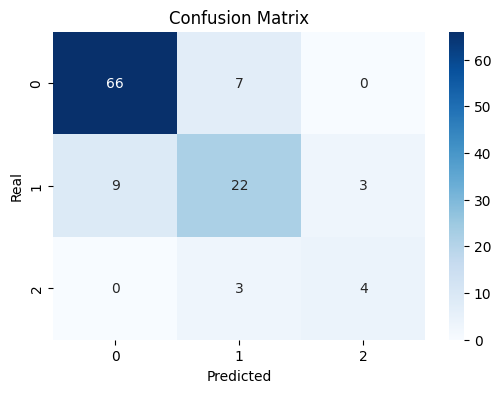

In [23]:
display_functions.plot_confusion_matrix(conf_matrix)

### Ploteamos la curva ROC

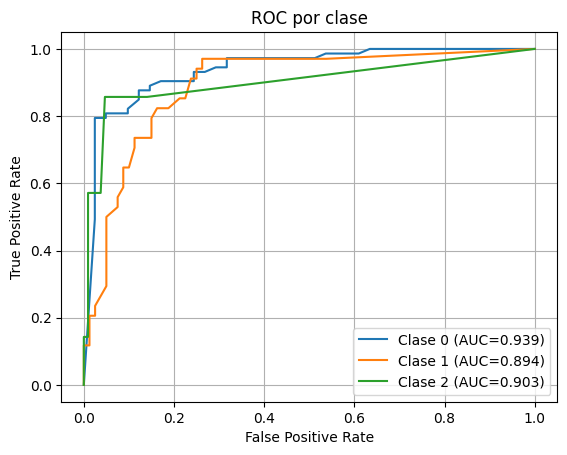

In [24]:
display_functions.plot_roc_curve(rf_best_model_selected,X_test, y_test)

## Save Random forest best model after atribute selecction

In [25]:
rf_best_model_selected_path = os.path.join(project_models, "rf_best_model_feature_importance.pkl")

model_functions.save_model(rf_best_model_selected, rf_best_model_selected_path)

### Nota: No mejora las métricas. El análisis de importancias debería usarse sólo como un análisis inicial, y contrastado con un análisis avanzado mediante modelos XAI.